

### Import 
#### run Notebook in Google colab with GPU runtime



In [2]:
# Import all the necessary Library 
import torchvision
import torch.utils.data as utils
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
import os
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd 


In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 4)

### Functions and setups

In [4]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [5]:
class SiameseNetworkDataset():
    
    def __init__(self,training_csv=None,training_dir=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns =["image1","image2","label"]
        self.training_dir = training_dir    
        self.transform = transform

    def __getitem__(self,index):
        
        # getting the image path
        image1_path=os.path.join(self.training_dir,self.training_df.iat[index,0])
        image2_path=os.path.join(self.training_dir,self.training_df.iat[index,1])
        
        
        # Loading the image
        img0 = Image.open(image1_path)
        img1 = Image.open(image2_path)
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        # Apply image transformations
        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))
    
    def __len__(self):
        return len(self.training_df)

In [6]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

        )
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))
        
  
  
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2


In [7]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [8]:
# To run in colab
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')


Mounted at /content/drive


### Data setup

In [39]:
datafolder = './drive/MyDrive/github_capstone/msca_capstone/data/manual-clusters/categorized_new/'

newlabels = []

for label in os.listdir(datafolder):
    for image in os.listdir(datafolder + label):
        newlabels.append({
            'filename': datafolder + label + "/" + image,
            'class_id': label,
            
        })
        
newlabels = pd.DataFrame(newlabels)
newlabels.replace({"class_id":{"01":"01", "02-round-end":"02","03-mib":"03","05-hole-flat":"04",
                               "07-honeycomb":"05","08":"06","11-longthin":"07"}}, inplace=True)

Generate a dataframe containing 3 variables: path for image1 and image2 and a label:1 -> two imgs are from the same class. 0 -> otherwise

In [40]:
df = newlabels.merge(newlabels, how="cross")
df.columns=["image1","class1","image2","class2"]
label = []
for index, row in df.iterrows():
    if row["class1"] == row['class2']:
        label.append(0)
    else:
        label.append(1)
df['label'] = label
df.drop(['class1','class2'], axis=1, inplace=True)

In [41]:
import numpy as np
from sklearn.model_selection import train_test_split

X = df.drop(['label'], axis=1)
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
X_train['label'] = y_train
X_test['label'] = y_test

In [42]:
X_train.to_csv("./drive/MyDrive/github_capstone/msca_capstone/data/siamese_training.csv", index=False)
X_test.to_csv("./drive/MyDrive/github_capstone/msca_capstone/data/siamese_testing.csv", index=False)
print(X_train['label'].value_counts())
print(X_test['label'].value_counts())

1    11676
0     2638
Name: label, dtype: int64
1    5004
0    1131
Name: label, dtype: int64


In [43]:
# To run in colab
training_csv = "./drive/MyDrive/github_capstone/msca_capstone/data/siamese_training.csv"
training_dir = ""
# Load the the dataset
siamese_dataset = SiameseNetworkDataset(training_csv,training_dir,
                transform=transforms.Compose([transforms.Resize((105,105)),
                                              transforms.ToTensor()
                                              ]))

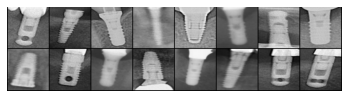

[[1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [44]:
# Viewing the sample of images and to check whether its loading properly
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(vis_dataloader)


example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

### Model training

In [46]:
class Config():
  # training_dir = ""
  # testing_dir = ""
  train_batch_size = 8
  train_number_epochs = 30

train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

In [47]:
# Declare Siamese Network
net = SiameseNetwork().cuda()
# Decalre Loss Function
criterion = ContrastiveLoss()
# Declare Optimizer
optimizer = optim.RMSprop(net.parameters(), lr=1e-4, 
                          alpha=0.99, eps=1e-8, weight_decay=0.0005, 
                          momentum=0.9)

In [48]:
def train():
    counter = []
    loss_history = [] 
    iteration_number= 0
    
    for epoch in range(0,Config.train_number_epochs):
        for i, data in enumerate(train_dataloader,0):
            img0, img1 , label = data
            img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
            optimizer.zero_grad()
            output1,output2 = net(img0,img1)
            loss_contrastive = criterion(output1,output2,label)
            loss_contrastive.backward()
            optimizer.step()
            if i %50 == 0 :
                print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
                iteration_number +=10
                counter.append(iteration_number)
                loss_history.append(loss_contrastive.item())
    return net

In [ ]:
%%time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Train the model
model = train()
torch.save(model.state_dict(), "./drive/MyDrive/github_capstone/msca_capstone/data/model.pt")
print("Model Saved Successfully")

In [30]:
# Load the test dataset
testing_csv = "./drive/MyDrive/github_capstone/msca_capstone/data/siamese_testing.csv"
test_dataset = SiameseNetworkDataset(training_csv=testing_csv,training_dir="",
                                        transform=transforms.Compose([transforms.Resize((105,105)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

test_dataloader = DataLoader(test_dataset,num_workers=6,batch_size=1)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
PATH = "./drive/MyDrive/github_capstone/msca_capstone/data/model.pt"
model = SiameseNetwork().cuda()
model.load_state_dict(torch.load(PATH))
model.eval()

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


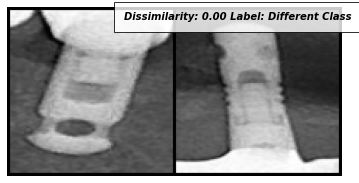

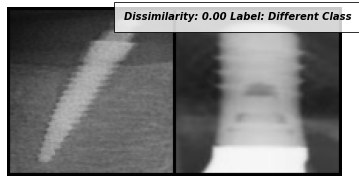

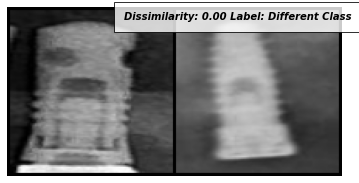

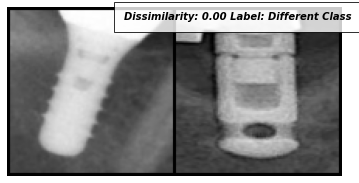

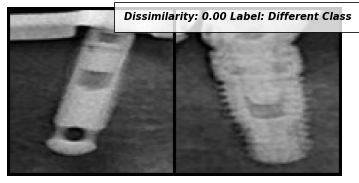

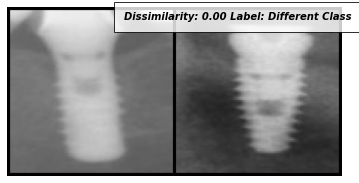

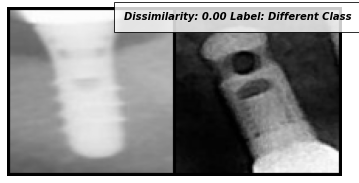

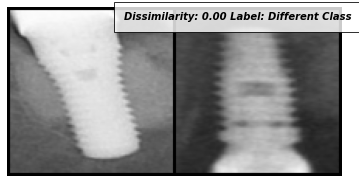

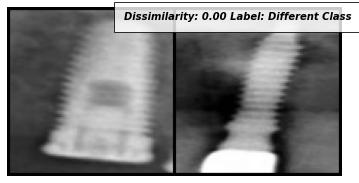

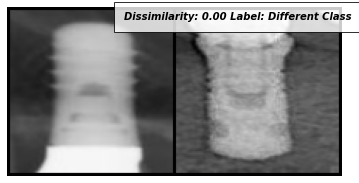

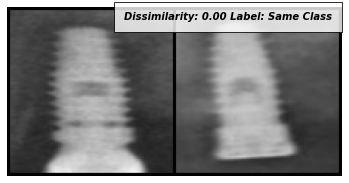

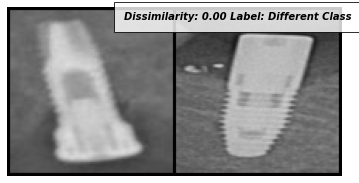

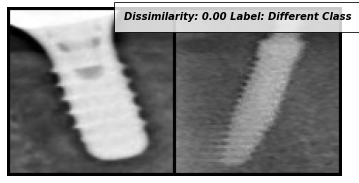

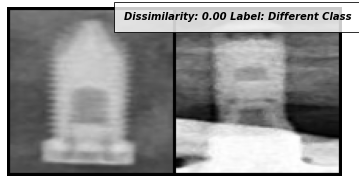

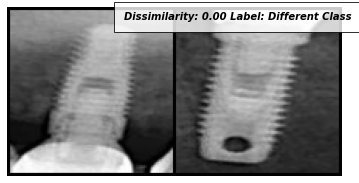

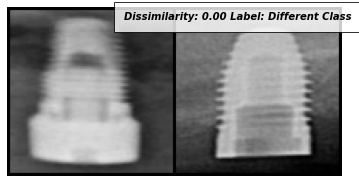

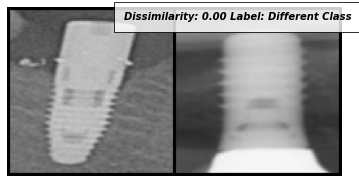

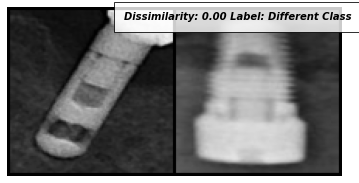

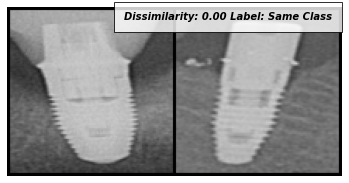

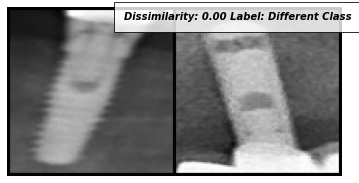

In [31]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  concatenated = torch.cat((x0,x1),0)
  output1,output2 = model(x0.to(device),x1.to(device))
  eucledian_distance = F.pairwise_distance(output1, output2)
  if label==list_0:
    label="Same Class"
  else:
    label="Different Class"
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
  counter=counter+1
  if counter ==20:
     break

### Evaluate Functions

In [9]:
def siamese_eval_dataload(test_image, datafolder):
  prediction_df = []
  for label in os.listdir(datafolder):
      for image in os.listdir(datafolder + label):
          prediction_df.append({
              'test_img':test_image,
              'img2': datafolder + label + "/" + image,
              'labels': label,   
          })
          
  prediction_df = pd.DataFrame(prediction_df)
  prediction_df.to_csv("./drive/MyDrive/github_capstone/msca_capstone/data/prediction.csv", index=False)

  # load prediction csv
  prediction_csv = "./drive/MyDrive/github_capstone/msca_capstone/data/prediction.csv"
          
  prediction_dataset = SiameseNetworkDataset(training_csv=prediction_csv,training_dir="",
                                          transform=transforms.Compose([transforms.Resize((105,105)),
                                                                        transforms.ToTensor()
                                                                        ]))

  prediction_dataloader = DataLoader(prediction_dataset,num_workers=6, batch_size=1)

  return prediction_df, prediction_dataloader

def siamese_eval(test_image, datafolder, net, n=3, metric='rmse'):
  prediction_df, prediction_dataloader = siamese_eval_dataload(test_image, datafolder)
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  dissimilarity = []

  # Get dissimilarity for every combination of test img and our imgs
  for i, data in enumerate(prediction_dataloader,0): 
      test, compare, label = data
      concatenated = torch.cat((test, compare),0)
      output1, output2 = net(test.to(device), compare.to(device))
      eucledian_distance = F.pairwise_distance(output1, output2)
      dissimilarity.append(eucledian_distance.item()*100)

  dissim_df = pd.DataFrame({"score":dissimilarity,
                            "labels":prediction_df['labels']})
  
  # Get avg dissimilarity score for each label
  labels = []
  scores = []
  rmsquares = []
  for label in set(prediction_df['labels']):
      scores_for_label = dissim_df[dissim_df['labels']==label]['score'].tolist()
      labels.append(label)
      scores.append(sum(scores_for_label)/len(scores_for_label))
      rmsquare = np.sqrt(np.mean(np.square(scores_for_label)))
      rmsquares.append(rmsquare)
      
  # Get labels and the corresponding avg score
  avg_score_df = pd.DataFrame({"labels":labels,
                              "score":scores,
                              "root_mean_squared":rmsquares})
  if metric == "rmse":
    top_n_pred = avg_score_df.sort_values("root_mean_squared", ascending=True)['labels'].head(n).tolist()
  else:
    top_n_pred = avg_score_df.sort_values("score", ascending=True)['labels'].head(n).tolist()
  return top_n_pred

### Eval

In [10]:
# set up to predict every images we have 
PATH = "./drive/MyDrive/github_capstone/msca_capstone/model/model.pt"
net = SiameseNetwork().cuda()
net.load_state_dict(torch.load(PATH))
net.eval()

datafolder = './drive/MyDrive/github_capstone/msca_capstone/data/manual-clusters/categorized_new/'
testimgs = []
for label in os.listdir(datafolder):
    for image in os.listdir(datafolder + label):
        testimgs.append({
            'dir': datafolder + label + "/" + image,
            'true_label': label,   
        })
testimgs = pd.DataFrame(testimgs)

In [11]:
# Get the predicated and true label
pred = []
true = []

from tqdm import tqdm
for i, row in tqdm(testimgs.iterrows()):
  test_image = row['dir']
  pred.append(siamese_eval(test_image, datafolder, net, n=3, metric='as'))
  true.append(row['true_label'])

0it [00:00, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
143it [04:34,  1.92s/it]


In [15]:
# Number of images with each labels
top_3_pred = pd.DataFrame({'pred':pred,
              'true':true})

top_3_pred['true'].value_counts()

6    44
5    23
2    22
3    19
1    17
4    11
7     7
Name: true, dtype: int64

In [16]:
# Top 1 accuracy for each label
correct = []
for i, row in top_3_pred.iterrows():
  if row['true'] in row['pred'][0]:
    correct.append(1)
  else:
    correct.append(0)
top_3_pred['correct'] = correct
print(top_3_pred.groupby(['true'])['correct'].mean())

# Top 1 accuracy for overall
top_3_pred['correct'].mean()

true
1    0.4706
2    0.0000
3    0.0526
4    0.0909
5    0.7391
6    0.3864
7    0.1429
Name: correct, dtype: float64


0.3146853146853147

In [17]:
# Top 2 accuracy for each label
correct = []
for i, row in top_3_pred.iterrows():
  if row['true'] in row['pred'][:2]:
    correct.append(1)
  else:
    correct.append(0)
top_3_pred['correct'] = correct
print(top_3_pred.groupby(['true'])['correct'].mean())

# Top 2 accuracy for overall
top_3_pred['correct'].mean()

true
1    0.7647
2    0.2273
3    0.0526
4    0.0909
5    0.9130
6    0.9545
7    0.1429
Name: correct, dtype: float64


0.5874125874125874